In [1]:
# Import lib
import ffmpeg
import numpy as np
import open_clip
import os
from PIL import Image
import time
import torch
from transnetv2pt import inference


z:\venv\qachatbot\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
z:\venv\qachatbot\lib\site-packages\transnetv2pt\inference.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setti

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [15]:
def read_video(filename, output_fps=24):
    video = None
    w = 48
    h = 27
    try:
        video_stream, err = (
            ffmpeg.input(
                filename,
            )
            .output(
                "pipe:",
                format="rawvideo",
                pix_fmt="rgb24",
                s=f"{w}x{h}",
                r=24,
            )
            .run(capture_stdout=True, capture_stderr=True)
        )
        video = np.frombuffer(video_stream, np.uint8).reshape([-1, h, w, 3])
    except ffmpeg.Error as e:
        print("stdout:", e.stdout.decode("utf8"))
        print("stderr:", e.stderr.decode("utf8"))
        raise e
    return video


def cut_frames(start_idx, end_idx):
    idx1 = int((end_idx - start_idx) / 3) + start_idx
    idx2 = int((end_idx - start_idx)*2 / 3) + start_idx
    frame_indices = [start_idx, idx1, idx2, end_idx]
    return frame_indices

def predict_video(filename_or_video, device=DEVICE):
    if isinstance(filename_or_video, str):
        video_stream, err = ffmpeg.input(filename_or_video).output(
            "pipe:", format="rawvideo", pix_fmt="rgb24", s="48x27"
        ).run(capture_stdout=True, capture_stderr=True)
        video = np.frombuffer(video_stream, np.uint8).reshape([-1, 27, 48, 3])
    else:
        assert filename_or_video.shape[1] == 27 and filename_or_video.shape[2] == 48 and filename_or_video.shape[3] == 3
        video = filename_or_video
    _, single_frame_pred, _ = inference.predict_raw(inference.model, video, device)
    scenes = inference.predictions_to_scenes(single_frame_pred)
    return scenes

In [4]:
import yt_dlp

youtube_id = "0ZZquVylLEo"
youtube_id = "9RhWXPcKBI8"
URL = f"https://www.youtube.com/watch?v={youtube_id}"

ydl_opts = {
    "format": "bestvideo[height<=360][ext=mp4][vcodec^=avc]+worstaudio[ext=m4a]/best[ext=mp4]/best",
    "subtitleslangs": ["en"],
    "skip_download": False,
    "outtmpl": "download/%(id)s.%(ext)s"
}
try:
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([URL])
except Exception as e:
    print(e)

[youtube] Extracting URL: https://www.youtube.com/watch?v=9RhWXPcKBI8
[youtube] 9RhWXPcKBI8: Downloading webpage
[youtube] 9RhWXPcKBI8: Downloading ios player API JSON
[youtube] 9RhWXPcKBI8: Downloading web creator player API JSON
[youtube] 9RhWXPcKBI8: Downloading m3u8 information
[info] 9RhWXPcKBI8: Downloading 1 format(s): 134+139-0
[download] download\9RhWXPcKBI8.mp4 has already been downloaded


In [5]:
filepath = f"download/{youtube_id}.mp4"
video_np = read_video(filepath)
video_info = ffmpeg.probe(filepath)
print(f"video duration: {video_info['format']['duration']}")
print(f"video_np shape: {video_np.shape}")


video duration: 1627.492533
video_np shape: (39061, 27, 48, 3)


In [9]:
# filepath = "content/9RhWXPcKBI8.mp4"
t0 = time.time()
scenes = predict_video(filepath)
print(f"\nProcess time: {time.time()-t0:.2f}s")

# or load scenes
# scenes_filepath = "content/scenes2.npy"
# scenes = np.load(scenes_filepath)

[TransNetV2] Processing video frames 48776/48776
Process time: 24.55s


In [20]:
48776/3592

13.579064587973274

In [19]:
cut_scenes = [cut_frames(scene[0], scene[-1]) for scene in scenes]
cut_scenes = np.array(cut_scenes).flatten()
cut_scenes.shape, scenes.shape

((3592,), (898, 2))

In [14]:
test_img = Image.fromarray(video_np[1093])

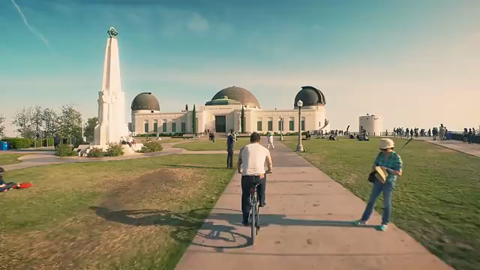

In [15]:
test_img

In [18]:
test_img.save('test.jpg')

In [12]:
model, _, preprocess = open_clip.create_model_and_transforms('coca_ViT-B-32', pretrained='laion2b_s13b_b90k')
model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
# tokenizer = open_clip.get_tokenizer('ViT-B-32')

# frame = video_np[0]
image = preprocess(Image.fromarray(video_np[1093])).unsqueeze(0)
# text = tokenizer(["a diagram", "a dog", "a cat"])

# im = Image.open("cat.jpg").convert("RGB")
# im = preprocess(im).unsqueeze(0)

with torch.no_grad(), torch.cuda.amp.autocast():
  generated = model.generate(image)

print(open_clip.decode(generated[0]).split("<end_of_text>")[0].replace("<start_of_text>", ""))


z:\venv\qachatbot\lib\site-packages\open_clip\factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=map_locatio

watch and share watch the first day of summer 2 0 1 9 in the united states of america gifs on gfycat 


In [21]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image

In [22]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

max_length = 32
num_beams = 6
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")
    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds


predict_step(['test.jpg'])
      

['two people walking in front of a large building']